# Project Context

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:


The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

<Strong> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

# 1. Import Libraries

In [25]:
#pip install matplotlib
#pip install wordcloud
#pip install transformers
#pip install ipywidgets
#pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
#pip install tensorflow
#pip install flax

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer

# 2. Data exploration

In [2]:
# Import data
train_df = pd.read_csv('C:/Users/TinyT/Downloads/Brandon HW2/train.csv',encoding='UTF-8')
test_df = pd.read_csv('C:/Users/TinyT/Downloads/Brandon HW2/test.csv',encoding='UTF-8')


### 2.1 Preview and check for NULL Values in train and test data

In [3]:
print('Train sample')
display(train_df.sample(5))
train_df.info()
print()
print()
print('Test sample')
display(test_df.sample(5))
test_df.info()

## CONCLUSION: There are no NULL values in text column for both train & test.

Train sample


,id,keyword,location,text,target
3199,4592,emergency%20plan,NaN,City of Calgary activates municipal emergency ...,1
2102,3019,death,NaN,RSS: Judge orders Texas to recognize spouse on...,0
6412,9169,suicide%20bomber,Indonesia,Suicide bomber kills 15 in Saudi security site...,1
3532,5049,eyewitness,Pennsylvania,A true #TBT Eyewitness News WBRE WYOU http://...,0
2641,3789,destruction,NaN,Marquei como visto Dragon Ball Super - 1x1 - T...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Test sample


,id,keyword,location,text
2703,9010,stretcher,SP - Brasil #1,WNBA: Stars coach Dan Hughes taken off court o...
2947,9767,trapped,NaN,Think of it as a reality TV show I tell myself...
1593,5390,fire%20truck,"Fredericksburg, VA",Last night was a ball! Atop a 40 ft. fire truc...
96,324,annihilated,NaN,@NinaHoag - 'if you shred my Psych work our fr...
1141,3767,destruction,Hell,@iam_destruction Okay.. I'll put my tail in fi...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### 2.2 Check for duplicates

In [4]:
duplicates = train_df.duplicated(subset=['text'], keep=False)
sum(duplicates)
## CONCLUSION: There are 179 duplicates records, we will proceed to drop those.

179

In [5]:
# Drop duplicates in training
train_df.drop_duplicates(subset=['text'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


### 2.3 Check for class balance in train_df

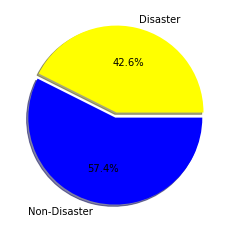

In [6]:
# Calculate disaster and non-disaster % in the df
disaster = round(train_df['target'].sum()/len(train_df),3)
non_disaster = round(1 - disaster,3)
# Set background color to white
plt.figure(facecolor='white')
# Plot pie chart
plt.pie(x=[disaster, non_disaster], labels=['Disaster', 'Non-Disaster'],explode=[0.03, 0.03], colors=['yellow', 'blue'], autopct='%1.1f%%', shadow=True, startangle=0)
# Show chart
plt.show()
## CONCLUSION: Class is balanced in the train_df.


### 2.4 Word Cloud

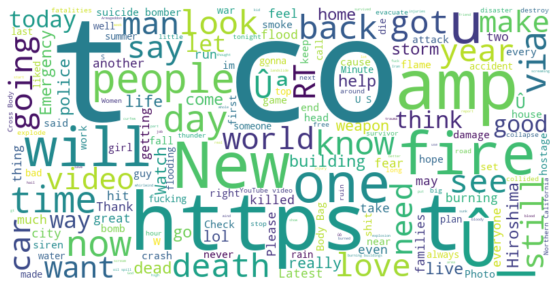

In [7]:
# Getting text_data 
text_data = ' '.join(train_df['text'])
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
## CONCLUSION: There are quite a few 'https' in the text, we will need to remove those as BERT preprocessing cannot take care of those.

### 2.5 More Data Exploration can be done on:
* Character length distritbution
* Sentence length distribution
* Location distribution [Might have potential language difference issue?]
* Key words frequency by disaster & non-disaster

# 3. Base Line Model

### 3.1 TBD

# 4. BERT Model

### 4.1 Text preprocessing

In [8]:
# Define text_preprocess functions
def text_preprocess(text):
    new_text = []
    for t in text.split(" "):
        # remove @metions
        t = '' if t.startswith('@') and len(t) > 1 else t
        # remove urls
        t = '' if t.startswith('http') else t
        # remove # from hashtag
        t = t.replace("#","")
        # set all words to lower case and append
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [9]:
# Apply text preprocessing function on train_df
train_df['clean_text'] = train_df['text'].apply(text_preprocess)
train_df.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


### 4.2 Tokenization

In [41]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [24]:
# Text embedding into tokens for BERT input
train_tokenize_inputs = tokenizer(train_df['clean_text'].tolist(), add_special_tokens = True, padding = 'max_length', truncation = True, max_length = 30, return_token_type_ids = False, return_tensors = 'tf')

## 有没有不需要用add_special_tokens的情况？ Yes, it is possible to use BERT-like models without using the [CLS] and [SEP] tokens, but it may require some modifications to the model architecture and training process. 这里说的modifications老师有什么experience上的example吗？

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train['target'].values))